In [1]:
import pandas as pd
import numpy as np 
import pandas as pd 
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models import Word2Vec


import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [2]:
# read in the data using Pandas
df = pd.read_csv('./globe_data/bostonglobe2018.csv')

In [3]:
print("shape: ",df.shape)
print("head: ",df.head)
print(df.isnull().sum())

df = df.dropna().reset_index(drop=True)
print(df.isnull().sum())

INFO - 19:07:23: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO - 19:07:23: NumExpr defaulting to 8 threads.


shape:  (8291, 1)
head:  <bound method NDFrame.head of                                                    text
0     ['\nMonday.\n\nOpen at owners’ discretion.\n\n...
1     ['Born a decade apart, Chuck Berry and Mary Ty...
2     ['\n\nThe idea that bigger is better in health...
3     ['With cyclists agitating for more safety meas...
4     ['A spout of fire that burst from a gas main o...
...                                                 ...
8286  ['\n\n\n fair. After years of bad policy decis...
8287  ['The governor, the mayor, the head of the Mas...
8288  ['The number of students disciplined in school...
8289  ['Hundreds of species are facing extinction du...
8290  ['Boston will record its warmest December in m...

[8291 rows x 1 columns]>
text    0
dtype: int64
text    0
dtype: int64


In [4]:
# removing special characters
def remove_specChar(df):

    spec_chars = ["!",'"',"#","%","&","'","(",")", "*","+",",",
                  "-",".","/",":",";","<", "=",">","?","@","[",
                  "\\","]","^","_", "`","{","|","}","~","–", 
                  "\xc2", "\xa0", "\x80", "\x9c", "\x99", "\x94", 
                  "\xad", "\xe2", "\x9d", "\n"]

    for char in spec_chars:
        df['text'] = df['text'].str.strip()
        df['text'] = df['text'].str.replace(char, ' ')
        
    return df


In [5]:
df = remove_specChar(df)
print("shape: ", df.shape)

shape:  (8291, 1)


In [6]:
#Bigrams=============================================================
'We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html'

'We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html'

In [7]:
# turn DataFrame into a list of lists of tokens
documents = []
for row in df.values:
    [row] = row
    temp = row.lower().split()
    documents.append(temp)
phrases = Phrases(documents, min_count=30, progress_per=10000)

INFO - 19:07:24: collecting all words and their counts
INFO - 19:07:24: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 19:07:31: collected 1040204 token types (unigram + bigrams) from a corpus of 6824711 words and 8291 sentences
INFO - 19:07:31: merged Phrases<1040204 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 19:07:31: Phrases lifecycle event {'msg': 'built Phrases<1040204 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 6.72s', 'datetime': '2021-06-22T19:07:31.314427', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [8]:
bigram = Phraser(phrases)
sentences = bigram[documents]
#print(sentences)

INFO - 19:07:31: exporting phrases from Phrases<1040204 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 19:07:33: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<2297 phrases, min_count=30, threshold=10.0> from Phrases<1040204 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 1.68s', 'datetime': '2021-06-22T19:07:33.005429', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [9]:
#check word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

79300

In [10]:
#Building the Vocabulary Table:
cores = multiprocessing.cpu_count()
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)
#Training of the model:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=10, report_delay=1)
w2v_model.init_sims(replace=True)

INFO - 19:07:38: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.03)', 'datetime': '2021-06-22T19:07:38.666441', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
INFO - 19:07:38: collecting all words and their counts
INFO - 19:07:38: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 19:07:44: collected 79300 word types from a corpus of 6555390 raw words and 8291 sentences
INFO - 19:07:44: Creating a fresh vocabulary
INFO - 19:07:44: Word2Vec lifecycle event {'msg': 'effective_min_count=20 retains 19149 unique words (24.147540983606557%% of original 79300, drops 60151)', 'datetime': '2021-06-22T19:07:44.343443', 'gensim': '4.0.1', 'python': '3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 19:07:44: Word2Vec lifecycle event {'msg':

In [11]:
#look up a list of the most similar words from keyword,"black"
w2v_model.wv.most_similar(positive=['black']) 

[('white', 0.7673226594924927),
 ('african_american', 0.6764353513717651),
 ('asian_american', 0.6038602590560913),
 ('asian', 0.5948810577392578),
 ('predominantly', 0.5506316423416138),
 ('dressed', 0.5359404683113098),
 ('color', 0.5199629068374634),
 ('latino', 0.5113626718521118),
 ('males', 0.5095081329345703),
 ('caucasian', 0.49799275398254395)]

In [12]:
#measure the similarity between any 2 words
w2v_model.wv.similarity('black', 'green')

0.15072677

In [13]:
#Analogy difference
#Which word is to "lation" as "black" is to "african_american"?
w2v_model.wv.most_similar(positive=["latino", "black"], negative=["african_american"], topn=3)

[('white', 0.5436479449272156),
 ('predominantly', 0.535384476184845),
 ('males', 0.5163706541061401)]

In [14]:
#t-SNE visualizations:=====================================

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

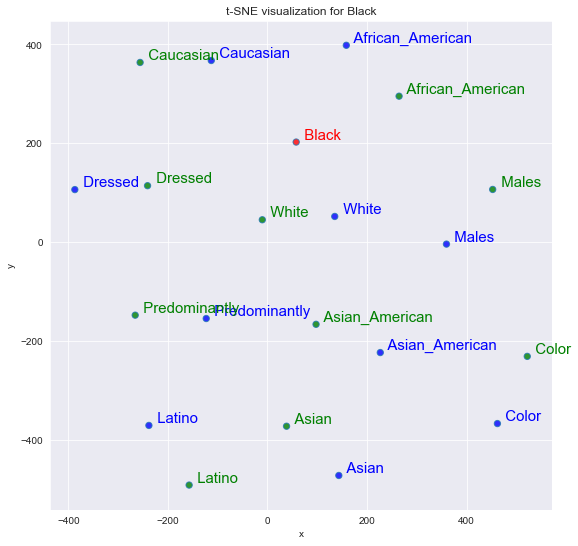

In [15]:
# the vector representation of "black" and 10 most similar words lies in a 2D graph.
tsnescatterplot(w2v_model, 'black', [i[0] for i in w2v_model.wv.most_similar(positive=['black'])])


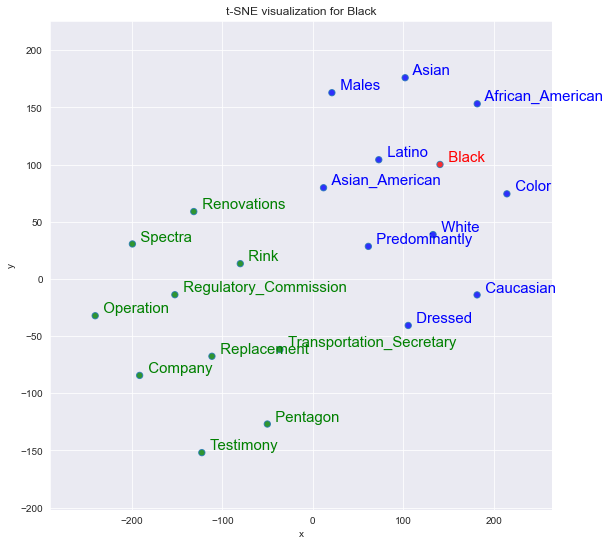

In [16]:
# the vector representation of "black" and 10 least similar words lies in a 2D graph.
tsnescatterplot(w2v_model, 'black', [i[0] for i in w2v_model.wv.most_similar(negative=['black'])])

In [17]:
w2v_model.wv.most_similar(negative=['black'])

[('replacement', 0.3242053985595703),
 ('regulatory_commission', 0.3223087787628174),
 ('company', 0.29238665103912354),
 ('spectra', 0.28767138719558716),
 ('pentagon', 0.27769172191619873),
 ('operation', 0.27544352412223816),
 ('rink', 0.27497997879981995),
 ('transportation_secretary', 0.27428847551345825),
 ('testimony', 0.2742670774459839),
 ('renovations', 0.2684938907623291)]